# Homework 3

**Bootstrap and Testing**

1. Test the hypothesis that the survival rates for female passengers in Pclass 1 was no larger than in Pclass 2.
2. Create a boxplot `mpg ~ cylinders`. It does seem that the mpg for cars with 4 cylinders is quite different from those with 3 cylinders. What does a bootstrap test tell you about this hypothesis?
3. Can you think of more interesting hypotheses to test regarding the pregnancy data ?

In [1]:
%run ../ourFunctions.py

## Task 1
Test the hypothesis that the survival rates for female passengers in Pclass 1 was no larger than in Pclass 2.

In [2]:
#Titanic data:
import seaborn as sns
titanic = sns.load_dataset('titanic')

### EDA

In [36]:
# Survival rate per class and sex
surv_rate_group = titanic[['survived', 'pclass', 'sex']].groupby(["pclass", "sex"]).mean()

# Survival rate for female passengers in Pclass 1 and Pclass 2
surv_rate_pcf1 = surv_rate_group.xs(key="female",level=1).iloc[0,0]
surv_rate_pcf2 = surv_rate_group.xs(key="female",level=1).iloc[1,0]

print("Survival rate for female passengers in Pclass 1",round(surv_rate_pcf1,2))
print("Survival rate for female passengers in Pclass 2",round(surv_rate_pcf2,2))

Survival rate for female passengers in Pclass 1 0.97
Survival rate for female passengers in Pclass 2 0.92


In [47]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

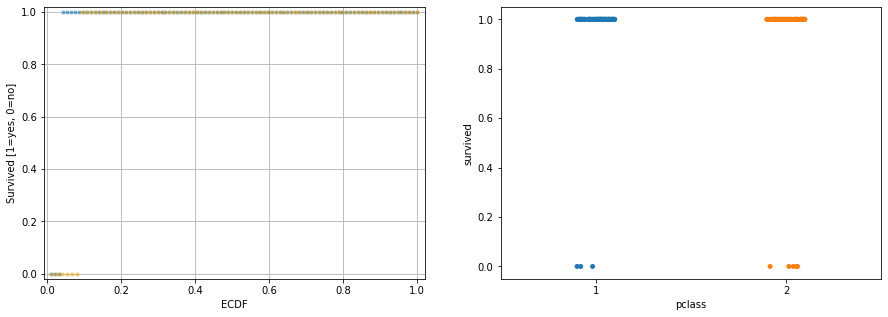

In [90]:
titanic_small = titanic[['survived', 'pclass', 'sex']]

# Filter df for female passengers in Pclass 1 and Pclass 2 
pcf1 =titanic_small[(titanic_small["sex"]=="female") & (titanic_small["pclass"]==1)]["survived"]
pcf2 =titanic_small[(titanic_small["sex"]=="female") & (titanic_small["pclass"]==2)]["survived"]

# Compute ECDF for female passengers in class 1 and 2 
x_1, y_1 = ecdf(pcf1)
x_2, y_2 = ecdf(pcf2)

#Create two subplots 
figure, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

#Plot 1:

# Plot all ECDFs on the same plot
ax1.plot(y_1, x_1, marker = '.', linestyle = 'none', alpha=0.5)
ax1.plot(y_2, x_2, marker = '.', linestyle = 'none', alpha=0.5, color="orange")

# Make nice margins
ax1.margins(0.02)
ax1.set_ylabel("Survived [1=yes, 0=no]")
ax1.set_xlabel("ECDF")

# Add grid
ax1.grid()

#--------------------------------------
#Plot 2:
female_both_classes = titanic_small[(titanic_small["sex"]=="female") & ((titanic_small["pclass"]==1) | (titanic_small["pclass"]==2))]
ax2 = sns.stripplot(x="pclass",y="survived", data=female_both_classes);


### Hypothesis testing through permutation sampling

1. Clearly state the null hypothesis: \
The survival rates for female passengers in Pclass 1 was not larger than in Pclass 2

2. Define your test statistic: \
Survival rate 
----
3. Generate many sets of simulated data assuming the null hypothesis is true (Permutation samples)

In [ ]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1,data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

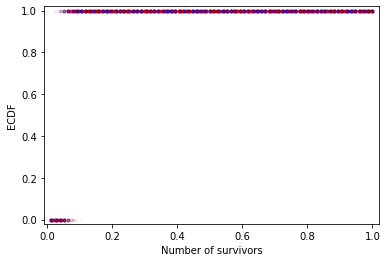

In [91]:
for i in range(0,50):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = permutation_sample(pcf1,pcf2)

    # Compute ECDFs
    yp_1, xp_1 = ecdf(perm_sample_1)
    yp_2, xp_2 = ecdf(perm_sample_2)

    # Plot ECDFs of permutation sample
    _ = plt.plot(xp_1, yp_1, marker='.', linestyle='none',
                 color='red', alpha=0.02)
    _ = plt.plot(xp_2, yp_2, marker='.', linestyle='none',
                 color='blue', alpha=0.02)

# Create and plot ECDFs from original data
y_1, x_1 = ecdf(pcf1)
y_2, x_2 = ecdf(pcf2)
_ = plt.plot(x_1, y_1, marker='.', linestyle='none', color='red', alpha=0.02)
_ = plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue', alpha=0.02)

# Label axes, set margin, and show plot
plt.margins(0.02)
_ = plt.xlabel('Number of survivors')
_ = plt.ylabel('ECDF')
plt.show()

ECDFs from the permutation samples do overlap with the observed data, suggesting that the hypothesis is commensurate with the data.

---
4. Compute the test statistic for each simulated data set

In [67]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1,data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)

    return perm_replicates

In [93]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1)-np.mean(data_2)

    return diff

In [94]:
# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(pcf1,pcf2)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(pcf1, pcf2, diff_of_means, size=10000)

5. Compute p-value: p

In [95]:
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)


p-value = 0.1564


**ANSWER:** 
The p-value tells us that there is about a 15,26% chance that we would get the difference of survival-rate observed in the experiment if survival rate for pclasses for female passengers were exactly the same. Since the p-value is above 0.05 the result is **not statistically significant**. We therefore reject the null hypothesis.

## Task 2
Create a boxplot `mpg ~ cylinders`. It does seem that the mpg for cars with 4 cylinders is quite different from those with 3 cylinders. What does a bootstrap test tell you about this hypothesis?

### Boxplot

3 cylinders: Mean: 20.55 Std: 2.221
4 cylinders: Mean: 29.284 Std: 5.656


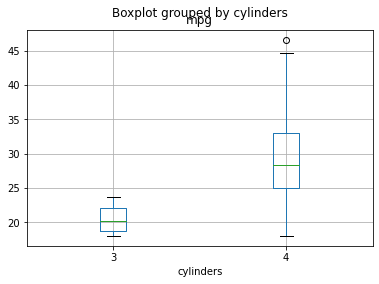

In [108]:
#Auto data:
cars = pd.read_csv('../data/Auto.csv')

#Filter df for cars with 3 or 4 cylinders
cars_cyl_34 = cars[(cars["cylinders"] == 3) | (cars["cylinders"] == 4)]

#Create boxplot
cars_cyl_34.boxplot("mpg", "cylinders");

#Print mean and std for both distributions:
print("3 cylinders: Mean:",round(np.mean(cars[cars["cylinders"] == 3]["mpg"]),3), "Std:",round(np.std(cars[cars["cylinders"] == 3]["mpg"]),3))
print("4 cylinders: Mean:",round(np.mean(cars[cars["cylinders"] == 4]["mpg"]),3), "Std:",round(np.std(cars[cars["cylinders"] == 4]["mpg"]),3))



### Bootstrap test

## Task 3
Can you think of more interesting hypotheses to test regarding the pregnancy data ?

In [13]:
#pregnancy data:
#preg=pd.read_hdf('../data/pregNSFG.h5', 'df')
preg = pd.read_csv("../data/pregNSFG.csv.gz").drop(["Unnamed: 0"],axis=1)

#only look at live births
live = preg[preg.outcome == 1]
live.head()

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw,totalwgt_lb
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,8.8125
1,1,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,7.8750
2,2,1,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,9.1250
3,2,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,7.0000
4,2,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,6.1875
